In [1]:
import VoxCeleb as VC

In [2]:
metadata_path = "voxceleb1_metadata.csv"
dev_audio_path = "processed/Processed/vox1_dev_wav/wav"
test_audio_path = "processed/Processed/vox1_test_wav/wav"

In [3]:
voxceleb_creater = VC.VoxCeleb(metadata_path, dev_audio_path, test_audio_path)

In [4]:
train_dataset, test_dataset, speaker_id_to_index, speaker_index_to_id = voxceleb_creater.create_train_and_test_datasets_and_speaker_to_index(minimum_frames=40,minimum_samples=45)

Splitting dataset into train and test
Filtering frames from datasets lower than 40
Filtering samples so each speaker only has 45 samples
Size of dataset is: 148637.
Cleaned dataset size is now: 54495.
Size of dataset is: 4874.
Cleaned dataset size is now: 1800.
Creating speaker id indexing lists
Creating VoxCelebDatasets


In [8]:
import torch.utils.data as data
batch_size = 50
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=True)

In [9]:
import torch.nn.functional as F
import torch.autograd as autograd
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, samples, hidden_dim, speaker_size, label_size, batch_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(samples, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, (hidden_dim*2))
        self.dropout = nn.Dropout(p=0.5)
        self.hidden2label = nn.Linear((hidden_dim*2), speaker_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.hidden = self.init_hidden()
#         self.lstm = nn.LSTM(input_size, hidden_layer_size)

#         self.l_out = nn.Linear(in_features=3000,
#                                out_features=speaker_size)

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(1, self.batch_size, self.hidden_dim).cuda()))

    def forward(self, x):


        lstm1, self.hidden = self.lstm(x, self.hidden)
        lstm2, self.hidden = self.lstm2(lstm1)
        x = self.dropout(lstm2[-2])
        x = self.hidden2label(x)
        x = self.softmax(x)
        #log_probs = F.log_softmax(y)
        return x

In [10]:
import torch
model = LSTM(samples=40, hidden_dim=100, speaker_size=len(speaker_index_to_id),label_size=len(speaker_index_to_id), batch_size=batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-06)

In [11]:
model = model.cuda()

In [12]:
epochs = 50

training_loss, validation_loss = [], []


for i in range(epochs):
    
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    model.train()
    
    for idx, (data_train, targets_train) in enumerate(train_dataloader):
        optimizer.zero_grad()
        model.batch_size = len(data_train)
        model.hidden = model.init_hidden()
        
        targets_idx = [speaker_id_to_index[speaker_id] for speaker_id in targets_train]
        
        targets_idx = torch.LongTensor(targets_idx)
        
        data_train = data_train.cuda()
        targets_idx = targets_idx.cuda()
        #print(data.shape)
        data_train = data_train.permute(1,0,2)
        #print(data.shape)
        outputs = model.forward(data_train)
        #print(outputs.shape)
        loss = criterion(outputs, targets_idx)
        
        loss.backward()
        optimizer.step()
        
        epoch_training_loss += loss.cpu().detach().numpy()  
    
    model.eval()
    
    for idx, (data_validate, targets_validate) in enumerate(test_dataloader):
        
        model.batch_size = len(data_validate)
        model.hidden = model.init_hidden()

        data_validate = data_validate.permute(1,0,2)
        data_validate = data_validate.cuda()
        
        
        outputs = model.forward(data_validate)
        
        targets_idx = [speaker_id_to_index[speaker_id] for speaker_id in targets_validate]
        targets_idx = torch.LongTensor(targets_idx)
        targets_idx = targets_idx.cuda()
        
        loss = criterion(outputs, targets_idx)
        
        # Update loss
        epoch_validation_loss += loss.cpu().detach().numpy()    
    
    training_loss.append(epoch_training_loss/len(train_dataloader))
    validation_loss.append(epoch_validation_loss/len(test_dataloader))

    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


Epoch 0, training loss: 7.122626191760422, validation loss: 9.731302950117323
Epoch 1, training loss: 7.076596659039138, validation loss: 10.759245846006605
Epoch 2, training loss: 7.00731082837516, validation loss: 11.4395960966746
Epoch 3, training loss: 6.921602523873705, validation loss: 11.985817485385471
Epoch 4, training loss: 6.854932804282652, validation loss: 12.087526851230198
Epoch 5, training loss: 6.802814822240707, validation loss: 12.168197472890219
Epoch 6, training loss: 6.764467342184224, validation loss: 12.184102296829224
Epoch 7, training loss: 6.723615717231681, validation loss: 12.198895454406738
Epoch 8, training loss: 6.680166013087701, validation loss: 12.21584545241462
Epoch 9, training loss: 6.639211928516353, validation loss: 12.279851463105944
Epoch 10, training loss: 6.589638600655652, validation loss: 12.222060362497965
Epoch 11, training loss: 6.561255525011535, validation loss: 12.121128824022081
Epoch 12, training loss: 6.520082388886618, validation 

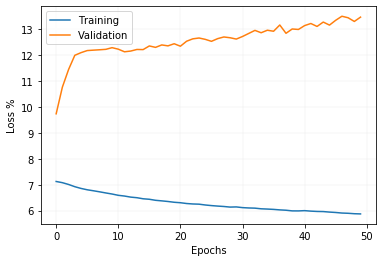

In [25]:
import matplotlib.pyplot as plt
plt.plot(training_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.grid(True, linewidth=0.1)
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.legend()
plt.savefig("lstm-training.png")

In [46]:
import pandas as pd
trials = pd.read_csv('voxceleb_verification_test.csv', delimiter=' ', names=['Target', 'Trial file 1', 'Trial file 2'])

In [47]:
import numpy as np
trials_results = pd.DataFrame(columns=['Targettype', 'Actual target', 'audio_file', 'Score for actual'])

model.eval()

for index, trial in trials.iterrows():
    trial_rpcc = np.load("{}/{}.npy".format(test_audio_path, trial['Trial file 2']))    
    trial_rpcc = torch.tensor(trial_rpcc[:13,:40]).unsqueeze(0)
    
    model.batch_size = len(trial_rpcc)
    model.hidden = model.init_hidden()

    trial_rpcc = trial_rpcc.permute(1,0,2)

    trial_rpcc = trial_rpcc.cuda()
    
    output = model(trial_rpcc)
    _, result = torch.max(output,1)
    
    result = result.cpu().detach().numpy()[0]
    
    speaker_result = speaker_index_to_id[result]
    
    trial_actual_target = str(trial['Trial file 1']).split('/')[0]
    speaker_actual = speaker_id_to_index[trial_actual_target]
    result_actual = output.cpu().detach().numpy()[0][speaker_actual]
    
    new_row = {'Targettype': trial['Target'], 'Actual target': trial_actual_target, 'audio_file': trial['Trial file 2'], 'Score for actual': result_actual}
    #print(new_row)
    trials_results = trials_results.append(new_row, ignore_index=True)
print(trials_results)

      Targettype Actual target                     audio_file  \
0              1       id10270  id10270/8jEAjG6SegY/00008.wav   
1              0       id10270  id10300/ize_eiCFEg0/00003.wav   
2              1       id10270  id10270/GWXujl-xAVM/00017.wav   
3              0       id10270  id10273/0OCW1HUxZyg/00001.wav   
4              1       id10270  id10270/8jEAjG6SegY/00022.wav   
...          ...           ...                            ...   
37715          0       id10309  id10302/K2_D_tFdAgY/00036.wav   
37716          1       id10309  id10309/0b1inHMAr6o/00010.wav   
37717          0       id10309  id10289/8l5ZnDf-FUA/00012.wav   
37718          1       id10309  id10309/rxnN8thYzEQ/00017.wav   
37719          0       id10309  id10296/Y-qKARMSO7k/00001.wav   

       Score for actual  
0            -12.284313  
1            -11.594401  
2            -12.971718  
3            -12.645391  
4            -13.747872  
...                 ...  
37715        -13.040292  
37716      

0.4972361708795613


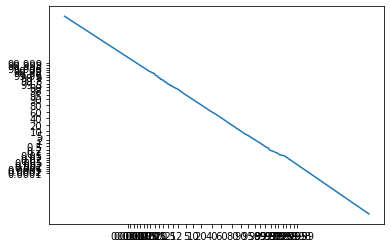

In [48]:
import bob.measure as bm
positives = trials_results.loc[trials_results['Targettype'] == 1]['Score for actual']
negatives = trials_results.loc[trials_results['Targettype'] == 0]['Score for actual']

eer=bm.eer_rocch(negatives,positives)

print(eer)
bm.plot.det(negatives, positives)

In [ ]:
import bob
from matplotlib import pyplot
# we assume you have your negatives and positives already split
npoints = 100
fig = pyplot.figure(figsize=(10,5))
bob.measure.plot.det(negatives, positives, npoints, color=(0,0,0), linestyle='-', label='test') 
bob.measure.plot.det_axis([1, 99.9, 1, 99.9]) 
pyplot.xlabel('FAR (%)') 
pyplot.ylabel('FRR (%)') 
pyplot.grid(True)
pyplot.show() 
fig.savefig("LSTM-Selvaraj-1")

In [ ]:
from VoxCelebPerformance import plot_det_and_save_fig_as as vcplot

vcplot(negatives, positives, "TestFile2", save=False)